In [1]:
# get data
import numpy as np
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
# Open trajectories

from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X)

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length set([500.0]) ns


In [4]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(1000L, 264L, 3L)
(1000L, 84L)


In [5]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000L, 84L)
(1000L, 4L)


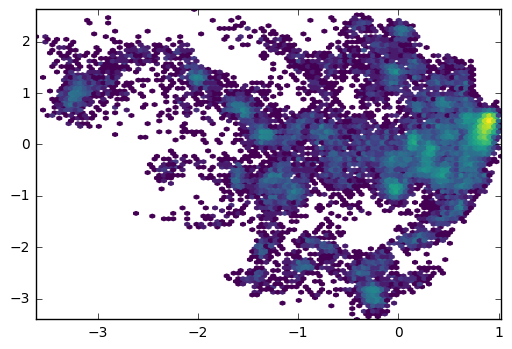

In [6]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [7]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans

num_cluster = 100
clusterer = MiniBatchKMeans(n_clusters=num_cluster, max_no_improvement=1000)
clustered_trajs = tica_trajs.fit_transform_with(clusterer, 'kmeans/', fmt='dir-npy')

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000L, 4L)
(1000L,)


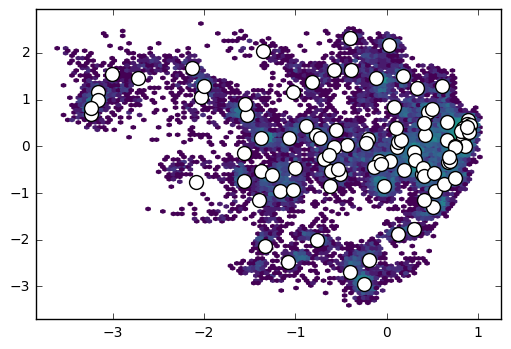

In [8]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [9]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20, ergodic_cutoff='on')
msm.fit(clustered_trajs)

MSM contains 2 strongly connected components above weight=0.50. Component 1 selected, with population 96.478672%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

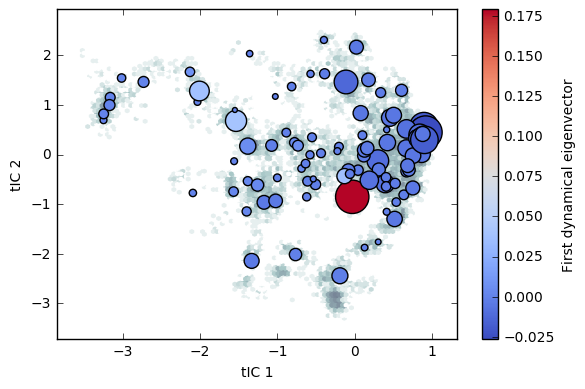

In [10]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [11]:
#Find frame limist
cluster_label = np.concatenate(clustered_trajs)
        
limit_list = []
state_list = []
for state in msm.mapping_.keys(): #goes through the original frame labels
    num_frame = np.where(cluster_label == state)[0].shape[0]
    prob = msm.populations_[msm.mapping_[state]]
    limit = num_frame/prob
    limit_list.append(limit)
    state_list.append(state)

limiting_state = state_list[np.argmin(limit_list)] #original frame label
max_frame = limit_list[msm.mapping_[limiting_state]]
print(limiting_state, max_frame)
print(max_frame*msm.populations_[msm.mapping_[limiting_state]], len(np.where(cluster_label == limiting_state)[0]))

(81, 13201.760137841848)
(158.0, 158)


In [12]:
# Sample based on population vector
num_frame = max_frame

if num_frame > max_frame:
    print("error: exceeding max number of frames ", max_frame)

num_state_frames = np.array(num_frame*msm.populations_).astype(int)

frame_idx = np.empty((0,))
for state in msm.mapping_.keys():
    options = np.where(cluster_label == state)[0]
    frame_idx = np.hstack((frame_idx,np.random.choice(options, num_state_frames[msm.mapping_[state]], replace=False)))
frame_idx = frame_idx.astype(int)

X_hat = X[frame_idx, :]
X_hat.dump('raw_XYZ_'+str(num_frame)+'.dat')
frame_idx.dump('indices_'+str(num_frame)+'.dat')

label_hat = np.repeat(list(msm.mapping_.keys()), num_state_frames)
print(label_hat)
print(len(np.unique(label_hat)))

[ 0  0  0 ..., 99 99 99]
97


In [13]:
# Using Min Cheol's code for plotting (the code is identical except for reading in the daata)
from msmbuilder.tpt import mfpts
from scipy import stats
fs_msm = msm
cluster_assignments = cluster_label
chosen_indices = frame_idx
fs_mfpt_matrix = (mfpts(fs_msm) + mfpts(fs_msm).T)/2

num_frames = X_hat.shape[0]
num_points = 500

0.585521176723


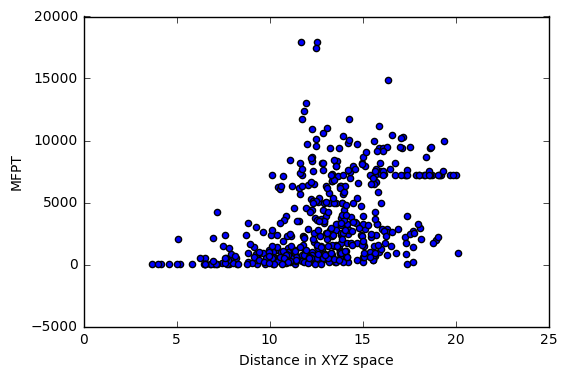

In [14]:
distances = []
mfpt_times = []
for p in range(num_points):
    frame_pair = np.random.randint(low=0, high=num_frames-1, size=2) # frame number in sim_data
    true_frame_pair = (int(chosen_indices[frame_pair[0]]), int(chosen_indices[frame_pair[1]])) # corresponding original frame numbers
    msm_frame_pair = (fs_msm.mapping_[cluster_assignments[true_frame_pair[0]]], fs_msm.mapping_[cluster_assignments[true_frame_pair[1]]])
    if msm_frame_pair[0] != msm_frame_pair[1] and fs_mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]] > 0:
        distances.append(np.linalg.norm(X_hat[frame_pair[0],:] - X_hat[frame_pair[1], :])) #@: X to X_hat
        mfpt_times.append(fs_mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]])

plt.scatter(np.array(distances), np.array(mfpt_times))
plt.xlabel('Distance in XYZ space')
plt.ylabel('MFPT')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(distances),np.log(np.log(np.array(mfpt_times))))
print(r_value)